# Exploratory study on existing early warning systems

## * Setup of the working environment *

### Import traditional Python packages

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime as dt, timedelta, date

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import time
import math
import json
import sys
import os

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Import custom Python modules

In [4]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from helpers.db_connector import MySQLConnector
from helpers.db_query import *

from helpers.data_process import *
from helpers.feature_extraction import *

from extractors.akpinar_et_al import AkpinarEtAl
from extractors.boroujeni_et_al import BoroujeniEtAl
from extractors.chen_cui import ChenCui
from extractors.he_et_al import HeEtAl
from extractors.lalle_conati import LalleConati
from extractors.lemay_doleck import LemayDoleck
from extractors.mbouzao_et_al import MbouzaoEtAl
from extractors.mubarak_et_al import MubarakEtAl
from extractors.wan_et_al import WanEtAl

from helpers.ml_utils import *

from helpers.time import *

## * Load the clickstream data *

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2018-2019**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

In [7]:
rounds = ['Y2-2018-19', 'Y3-2019-20']

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [8]:
%time userData = getUserInfo(prior_knowledge=True)

CPU times: user 55.7 s, sys: 2.24 s, total: 57.9 s
Wall time: 1min 59s


Given that the Y1-2017-2018 round included only one week in a flipped classroom setting, we will remove the students of that round.  

In [9]:
userData = userData[userData['Round'].isin(rounds)]

Some of the statistics on the user data are provided below. 

In [10]:
"Number of students:", len(userData)

('Number of students:', 214)

### Getting Students' Records

#### Exam Records

In [11]:
%time examData = getExamInfo()

CPU times: user 55.3 s, sys: 2.08 s, total: 57.4 s
Wall time: 1min 54s


In [12]:
examData = examData[examData['Round'].isin(rounds)]

In [13]:
examData = examData[examData['AccountUserID'].isin(userData['AccountUserID'])]

In [14]:
"Number of graded students:", len(examData)

('Number of graded students:', 214)

## * Cross validation of early warning systems *

#### Parameters

In [15]:
mode = 'random'
task = 'binary'
ratio = 80
start, end, step = 5, 15, 1
iterations = 3

In [16]:
weeks = np.arange(start + 1, end, step)

#### Feature Sets

In [17]:
featureSets = loadFeatureSets(mode, task, ratio, start, end, step)

> Found features for this experimental setting in ../data/feature_sets/feature_sets_random_binary_80_5-15-1.pkl


In [18]:
def concat_features(featureSets):
    """Concatenate feature vectors from different papers into a single one"""
    features = {}
    dump_name = 'all'
    features[dump_name] = {}
    for wid in weeks:
        concat = []
        for flabel in featureSets.keys():
            concat.append(featureSets[flabel][wid])
        features[dump_name][wid] = np.hstack(concat)
    print("Number of features:",features[dump_name][wid].shape[1])
    return features

In [19]:
all_featureSets = concat_features(featureSets)
featureSets['all'] = all_featureSets['all']

Number of features: 4157


In [20]:
for flabel in featureSets.keys():
    print(flabel)
    print(featureSets[flabel][14].shape)

akpinar_et_al
(214, 4100)
boroujeni_et_al
(214, 12)
chen_cui
(214, 11)
he_et_al
(214, 3)
lalle_conati
(214, 21)
lemay_doleck
(214, 10)
all
(214, 4157)


#### Models and Metrics

In [58]:
LOAD_MODEL = True
SAVE_MODEL = False
MODEL_NAME = '20_fine_split_cv_lasso'

evaluationMetrics = {'Acc': accuracy_score, 'F1': f1_score, 'P': precision_score, 
                             'R': recall_score, 'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp }

In [59]:
if LOAD_MODEL:
    tunedModels, scaler, SEED = loadTrainedModels(MODEL_NAME, mode, task, ratio, start, end, step)
    x_train, x_test, y_train, y_test = getTrainTestData(examData, mode, task, ratio / 100.0, random_state=SEED)
    evaluationScores = computeMetrics(scaler, featureSets, tunedModels, x_test, y_test, evaluationMetrics, {})

> Found models for this experimental setting in ../data/trained_models/trained_models_20_fine_split_cv_lasso_random_binary_80_5-15-1.pkl
> Binarizing student grades: [(0, 134), (1, 80)]
> Splitting the whole student population randomly: Train 171 [(0, 107), (1, 64)] - Test 43 [(0, 27), (1, 16)]
> Evaluated last iteration models


## Visualize performance

In [60]:
lst_data = []
lst_name = []
for flabel in evaluationScores.keys():
    for wid in evaluationScores[flabel].keys():
        for mid in evaluationScores[flabel][wid].keys():
            lst_data.append([wid, flabel, mid] + [np.mean(value) if i <=3 or i >=8 else np.around(np.mean(value)) for i, value in enumerate(evaluationScores[flabel][wid][mid].values())])  
            lst_name = ['week', 'set','clf'] + [emid for emid, _ in evaluationScores[flabel][wid][mid].items()]
#             lst_name.append('Nb coef')
#             lst_data[-1].append((trainedModels[flabel][wid][mid][-1].best_estimator_.coef_[0] != 0).sum())
            
df_results = pd.DataFrame(lst_data, columns = lst_name)
df_results[(df_results['clf'] == 'las')].set_index(['week', 'set','clf'])
#[(df_results['week'] == 14) & (df_results['clf'] == 'lr')]

Acc        F1         P       R   TP    FN    TN  \
week set           clf                                                          
6    akpinar_et_al las  0.511628  0.432432  0.380952  0.5000  8.0   8.0  14.0   
7    akpinar_et_al las  0.534884  0.375000  0.375000  0.3750  6.0  10.0  17.0   
8    akpinar_et_al las  0.534884  0.285714  0.333333  0.2500  4.0  12.0  19.0   
9    akpinar_et_al las  0.604651  0.451613  0.466667  0.4375  7.0   9.0  19.0   
10   akpinar_et_al las  0.604651  0.484848  0.470588  0.5000  8.0   8.0  18.0   
...                          ...       ...       ...     ...  ...   ...   ...   
     all           las  0.558140  0.457143  0.421053  0.5000  8.0   8.0  16.0   
11   all           las  0.488372  0.352941  0.333333  0.3750  6.0  10.0  15.0   
12   all           las  0.534884  0.375000  0.375000  0.3750  6.0  10.0  17.0   
13   all           las  0.534884  0.333333  0.357143  0.3125  5.0  11.0  18.0   
14   all           las  0.604651  0.484848  0.470588  0.5000  8.0   8.0  18.0   

                          FP  
week set           clf        
6    akpinar_et_al las  13.0  
7    akpinar_et_al las  10.0  
8    akpinar_et_al las   8.0  
9    akpinar_et_al las   8.0  
10   akpinar_et_al las   9.0  
...                      ...  
     all           las  11.0  
11   all           las  12.0  
12   all           las  10.0  
13   all           las   9.0  
14   all           las   9.0  

[63 rows x 8 columns]

In [61]:
def plot_metrics_per_model(df_results, weeks, emid, clf):

    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.title(clf)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    
    for i, flabel in enumerate(np.unique(df_results['set'])):    
        df_features = df_results[df_results['set'] == flabel]
        
        for j, mid in enumerate(np.unique(df_features['clf'])): 
            if mid == clf:
                df_classifiers = df_features[df_features['clf'] == mid]
                plt.plot(weeks, df_classifiers[emid].values, lw=1, color=colors[i], label=flabel)
            
    plt.ylim([0.4, 0.75])
    plt.xlim([weeks[0], weeks[-1]])
    plt.xlabel('Course week')
    plt.ylabel(emid)
    plt.grid(axis='y')
    plt.legend(loc='upper left')

In [118]:
def plot_metrics_per_feature(df_results, weeks, emid, flabel):

    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
    df_features = df_results[df_results['set'] == flabel]

    plt.title(flabel)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 10)]

    for j, mid in enumerate(np.unique(df_features['clf'])): 
        df_classifiers = df_features[df_features['clf'] == mid]
        plt.plot(weeks, df_classifiers[emid].values, lw=1, color=colors[j], label=mid)

    plt.axhline(y=.62, xmin=6, xmax=14, linestyle='--', color='red')    
        
    plt.ylim([0.4, 0.75])
    plt.xlim([weeks[0], weeks[-1]])
    plt.xlabel('Course week')
    plt.ylabel(emid)
    plt.grid(axis='y')
    plt.legend(loc='upper left')

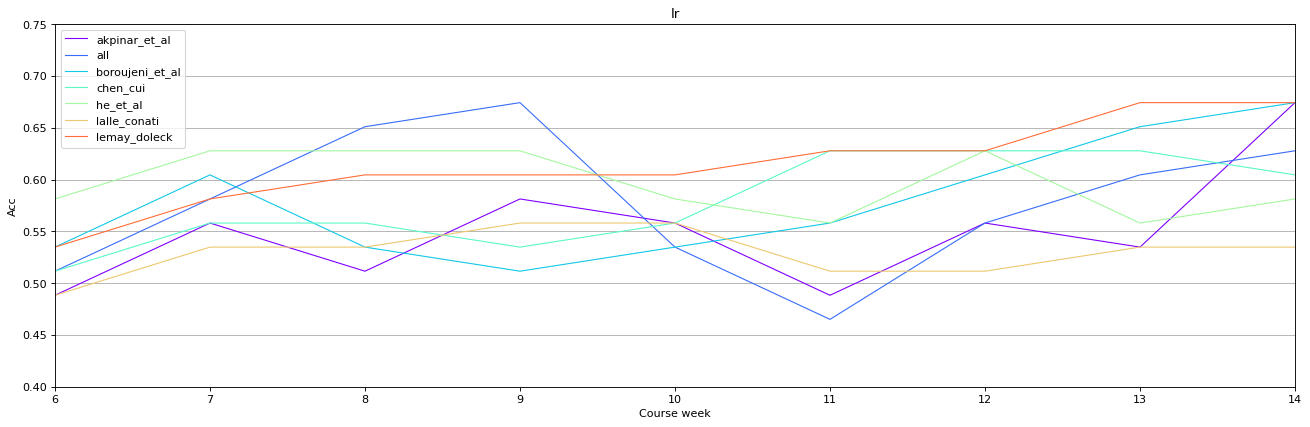

In [119]:
plot_metrics_per_model(df_results, weeks, 'Acc', 'lr')

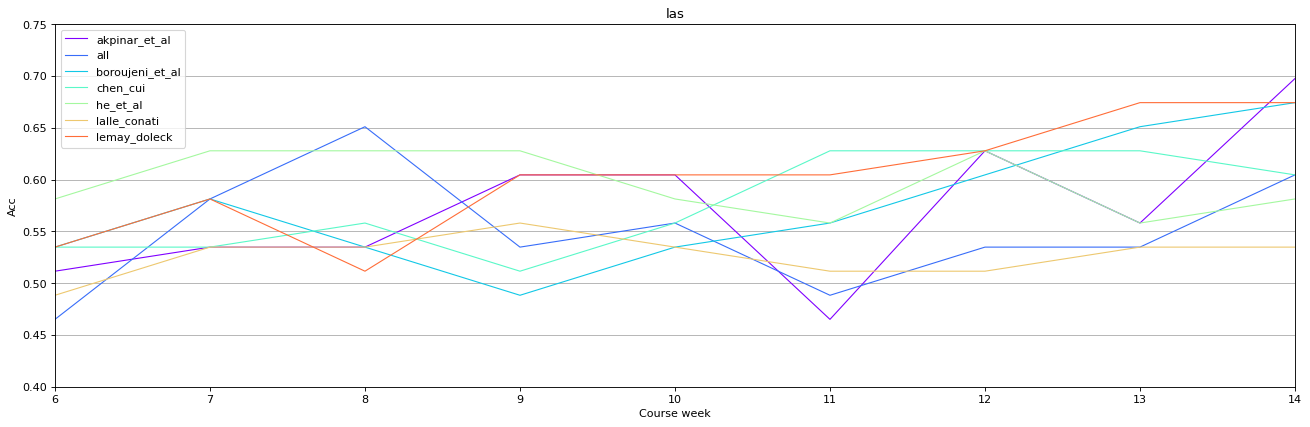

In [64]:
plot_metrics_per_model(df_results, weeks, 'Acc', 'las')

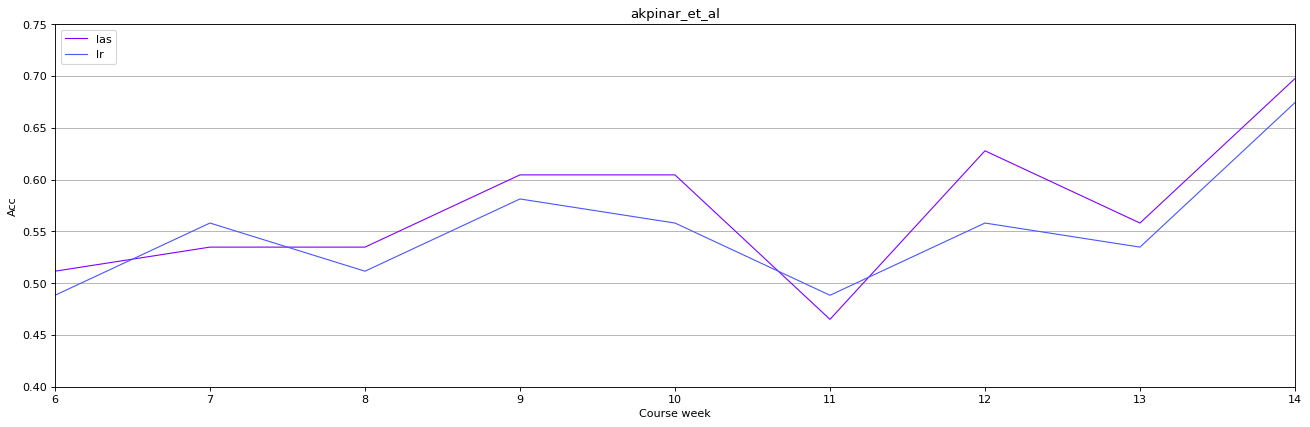

In [65]:
plot_metrics_per_feature(df_results, weeks, 'Acc', 'akpinar_et_al')

## Aggregated papers analysis

### Density by paper

Let's compute the contribution by paper. For that we will compute the absolute sum of each coefficient across all weeks and order them 

In [222]:
def aggregate_coef(featureSets,tunedModels, paper):
    nb_students, nb_features = featureSets['all'][6].shape

    coef_abs_sum = np.zeros(nb_features)
    coef_sum = np.zeros(nb_features)
    for windex, wid in enumerate(weeks):
        weekly_coefs = tunedModels['all'][wid]['las'].coef_[0]
        coef_abs_sum += np.abs(weekly_coefs)
        coef_sum += weekly_coefs
    return coef_abs_sum, coef_sum

coef_abs_sum, coef_sum = aggregate_coef(featureSets, tunedModels, 'all')

In [223]:
#Initialize all extractors
akpinar = AkpinarEtAl()
boroujeni = BoroujeniEtAl()
chen_cui = ChenCui()
he = HeEtAl()
lalle_conati = LalleConati()
lemay_doleck = LemayDoleck()

KeyboardInterrupt: 

In [224]:
akpinar.getNbFeatures()

4100

In [72]:
papers = [akpinar, boroujeni, chen_cui, he, lalle_conati, lemay_doleck]
paper_names = list(map(lambda x: x.__class__.__name__, papers))

In [225]:
paper_partition = [0]
abs_sum = []
prop = []
last_idx = 0

for paper in papers:
    nb_features = paper.getNbFeatures()
    paper_partition.append(last_idx + nb_features)
    paper_coefs = coef_abs_sum[last_idx: last_idx + nb_features].sum()
    abs_sum.append(paper_coefs)
    prop.append(paper_coefs / nb_features)
    last_idx += nb_features

pd.DataFrame(data = [abs_sum, prop], columns= paper_names, index=['Absolute sum of coefficients', 'Coef contribution over nb of features'])

,AkpinarEtAl,BoroujeniEtAl,ChenCui,HeEtAl,LalleConati,LemayDoleck
Absolute sum of coefficients,695.646917,23.850498,36.304443,4.358437,55.325438,10.661675
Coef contribution over nb of features,0.169670,1.987541,3.300404,1.452812,2.634545,1.066167


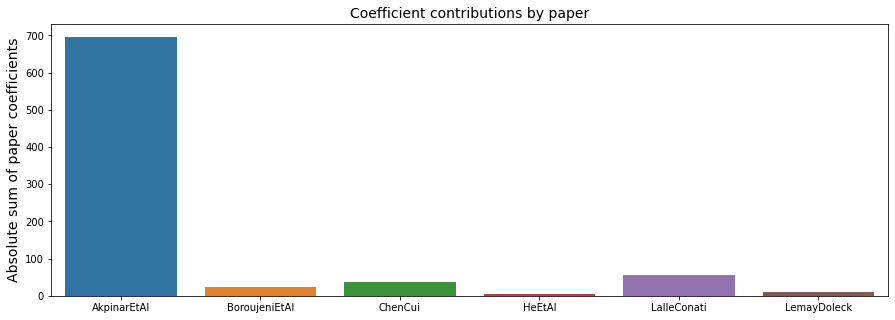

In [74]:
plt.figure(figsize=(15,5))
plt.title("Coefficient contributions by paper", fontSize=14)
plt.ylabel("Absolute sum of paper coefficients", fontSize=14)
sns.barplot(x=paper_names, y=abs_sum);

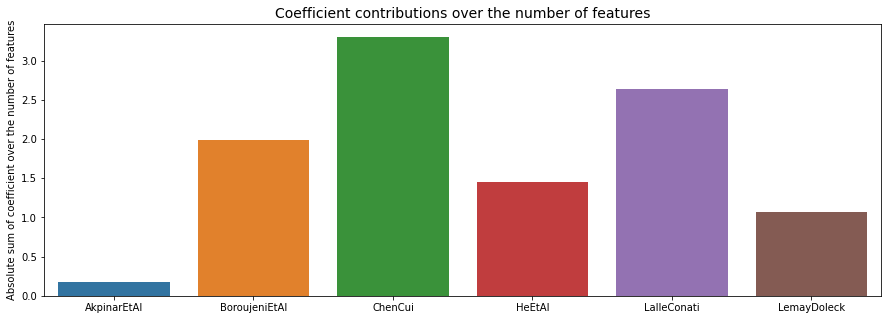

In [75]:
plt.figure(figsize=(15,5))
plt.title("Coefficient contributions over the number of features", fontSize=14)
plt.ylabel("Absolute sum of coefficient over the number of features")
sns.barplot(x=paper_names, y=prop);

### Best coefficients

Let's find which coefficients has the most contributions among all the features.

In [79]:
nb_best_coef = 10 #Number of coefficient we want

#Select the specified coef
best_idx = (-coef_abs_sum).argsort()
top_idx = best_idx[:nb_best_coef]
top_coef = coef_abs_sum[top_idx]
top_mean_coef = coef_sum[top_idx]#/ nb_students

In [80]:
#Associate each coef with the corresponding paper and feature
paper_attribution = np.digitize(top_idx, paper_partition)
paper_feature_idx = []
for i, coef_idx in enumerate(top_idx):
        paper_feature_idx.append(coef_idx - paper_partition[paper_attribution[i] - 1])
        
best_coef_paper = np.array(papers)[paper_attribution - 1]
best_coef_paper_names = np.array(paper_names)[paper_attribution - 1]
couple_paper_idx = list(zip( best_coef_paper, best_coef_paper_names, paper_feature_idx))

In [84]:
#Display values
feat_array = []
for i, (paper, paper_name,feat_idx) in enumerate(couple_paper_idx):
    feat_array.append([paper.getFeatureNames()[feat_idx], paper_name, top_coef[i], 
                       top_mean_coef[i], top_mean_coef[i] / nb_students])
pd.DataFrame(data=feat_array, columns=['Feature','Paper', 'Absolute coef sum',
                                       'Coef sum', 'Mean value']).set_index("Feature")

,Paper,Absolute coef sum,Coef sum,Mean value
Feature,,,,
"(Video.Play, Video.Play, Problem.Check)",AkpinarEtAl,12.819566,-12.819566,-0.059905
"(Video.Play, Video.Load, Video.Seek)",AkpinarEtAl,11.784840,11.784840,0.055069
attendanceVideos,AkpinarEtAl,11.311020,9.578283,0.044758
totalClicksWeekends,ChenCui,10.252448,-10.252448,-0.047909
freqAllActions,LalleConati,9.416002,9.416002,0.044000
"(Video.SpeedChange, Video.Pause, Video.SpeedChange)",AkpinarEtAl,9.351090,9.351090,0.043697
"(Video.Seek, Video.Pause, Problem.Check)",AkpinarEtAl,8.971870,-8.971870,-0.041925
"(Video.Load, Video.Load, Video.Load)",AkpinarEtAl,8.041027,8.041027,0.037575
avgWeeklyPropReplayed,LalleConati,7.790315,-7.790315,-0.036403


## Weekly analysis

Let's now analyze how the different coefficients and regularizations terms evolve over weeks.

### Regularization term evolution

In [214]:
def plot_reg_paper(paper, tunedModels, clf_name, log=True, inv=True, color=None, label=None):
    weeks = list(tunedModels[paper].keys())
    reg = np.array([tunedModels[paper][wid][clf_name].C for wid in weeks])
    if inv:
        reg = 1 / reg
    if log:
        reg = np.log10(reg)
    if not color:
        colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
        color = colors[list(tunedModels.keys()).index(paper)]
    plt.plot(weeks, reg, color=color, label=label if label else paper)

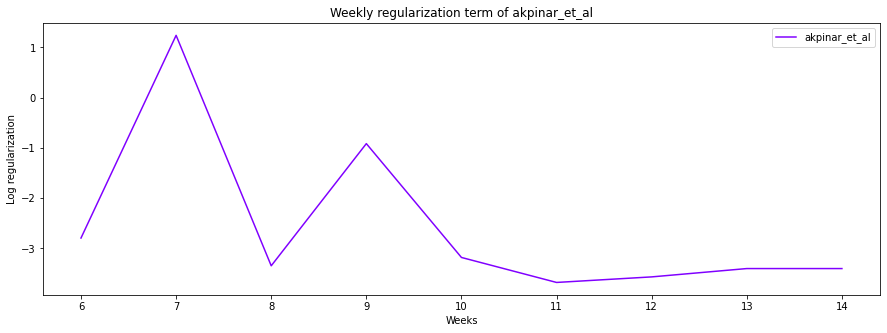

In [221]:
paper = 'akpinar_et_al'
plt.figure(figsize=(15,5))
plot_reg_paper(paper, tunedModels, 'las')
plt.title(f"Weekly regularization term of {paper}")
plt.ylabel("Log regularization")
plt.xlabel("Weeks")
plt.legend()
plt.show()

In [219]:
def plot_regularization(tunedModels, log=True, inv=True):
    plt.figure(figsize=(15,7))
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]

    for i, paper in enumerate(tunedModels.keys()):
        plot_reg_paper(paper, tunedModels, 'las', log, inv, color=colors[i])
    
    plot_reg_paper(paper, tunedModels, 'lr', log, inv, color=colors[-1], label='baseline')
        
    fontsize=14
    ylabel = ('log ' if log else '') + 'regularization'
    plt.ylabel(ylabel.capitalize(), fontSize=fontsize)
    plt.xlabel("Weeks", fontSize=fontsize)
    plt.title(f"Weekly regularization terms",fontSize=fontsize)
    plt.legend(loc='best', bbox_to_anchor=(1., 1.))

    plt.show()

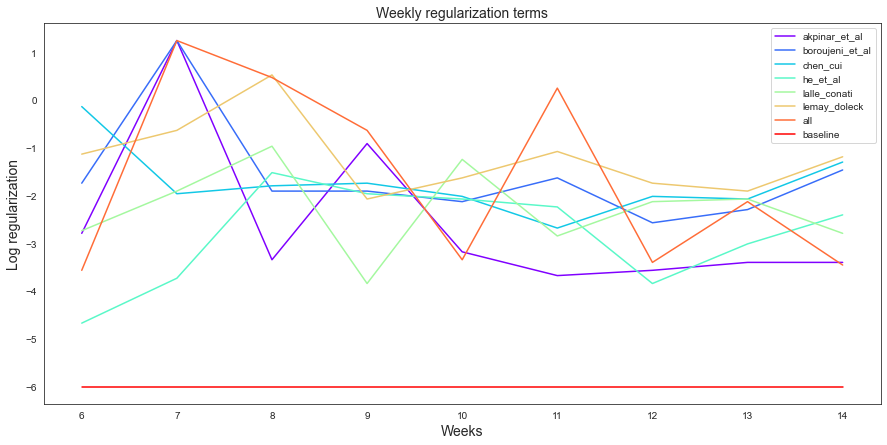

In [300]:
plot_regularization(tunedModels)

### Coefficient evolution

In [319]:
def plot_best_coef_paper(featureSets, tunedModels, paper, featureNames):
    best_coef_idx, best_coef_abs_val, best_coef_val , best_coef_name = [], [], [], [] #best accordint to abs value
    coef_abs_sum, coef_sum = aggregate_coef(featureSets, tunedModels, paper)
    weeks = list(tunedModels[paper].keys())
    
    #Find the best coefficients 
    for wid in weeks:
        weekly_coefs = tunedModels[paper][wid]['las'].coef_[0]
        idx = np.argmax(abs(weekly_coefs))
        best_coef_idx.append(idx)
        best_coef_abs_val.append(abs(weekly_coefs)[idx])
        best_coef_val.append(weekly_coefs[idx])
        best_coef_name.append(featureNames[idx])
    
    fig = plt.figure(figsize=(15,10))
    plt.plot(weeks, best_coef_abs_val, label="greatest coefficient magnitude")

    fontsize= 14
    #Write the coef name corresponding to each points
    for i, name in enumerate(best_coef_name):
        x= weeks[i]
        y=best_coef_abs_val[i]
        plt.annotate(name, (x,y), fontSize=fontsize)
    sns.despine()
    plt.title(f"Weekly best coefficient for {paper}", fontSize=fontsize + 2)
    plt.ylabel("Absolute value of the coefficients", fontSize=fontsize)
    plt.xlabel("Weeks", fontSize=fontsize)
    plt.legend()
    plt.axis()
    plt.show()
    
    
    cols=['Week', 'Best coefficient name', 'Absolute value', 'Value']
    data= np.array([weeks, best_coef_name, best_coef_abs_val, best_coef_val]).transpose()
    return pd.DataFrame(data=data, columns=cols).set_index('Week')

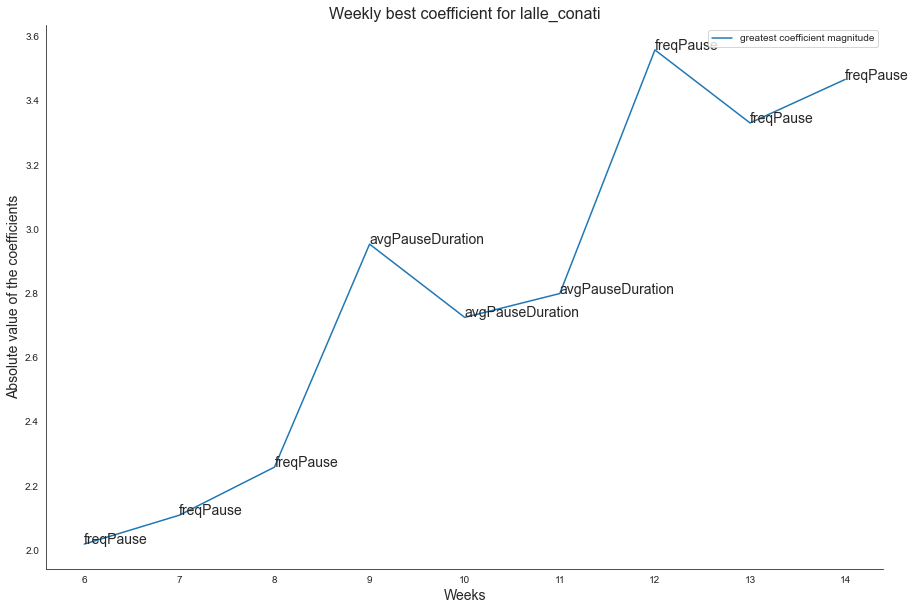

In [327]:
df = plot_best_coef_paper(featureSets, tunedModels, 'lalle_conati', lalle_conati.getFeatureNames())

In [328]:
df

,Best coefficient name,Absolute value,Value
Week,,,
6,freqPause,2.018931063954415,2.018931063954415
7,freqPause,2.1089687744049894,2.1089687744049894
8,freqPause,2.2587097092384343,2.2587097092384343
9,avgPauseDuration,2.9533464315625113,-2.9533464315625113
10,avgPauseDuration,2.7251195779844752,-2.7251195779844752
11,avgPauseDuration,2.7994917050273536,-2.7994917050273536
12,freqPause,3.558346564565186,3.558346564565186
13,freqPause,3.330846784511115,3.330846784511115
14,freqPause,3.466353967375014,3.466353967375014


In [331]:
def plot_best_coef(featureSets, tunedModels):
    for i, paper in enumerate(papers):
        plot_best_coef_paper(featureSets, tunedModels, list(featureSets.keys())[i], paper.getFeatureNames())

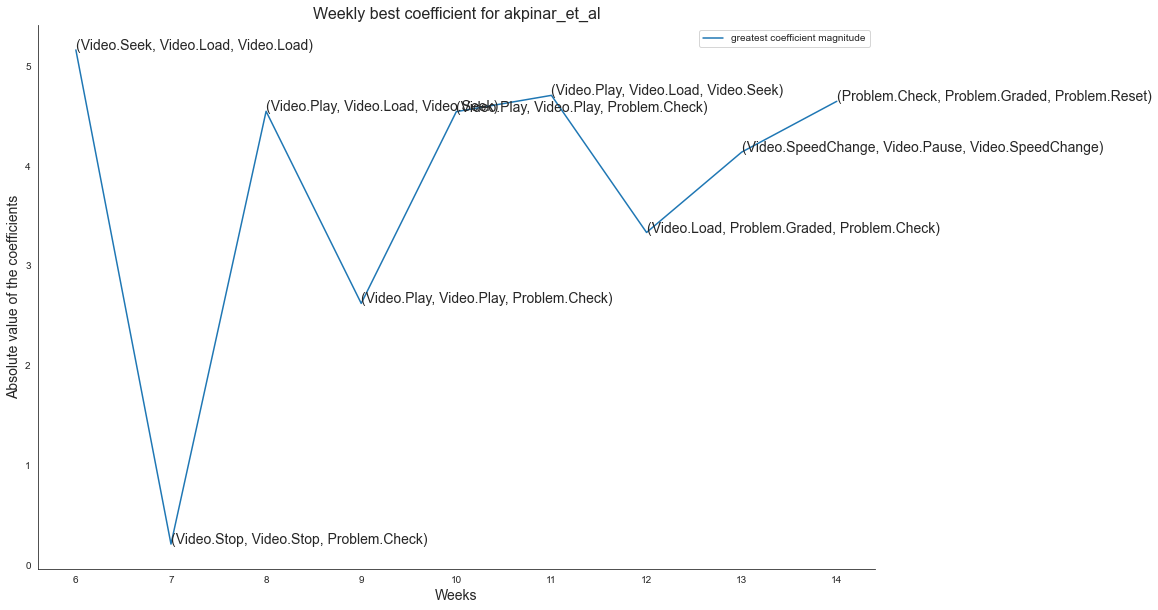

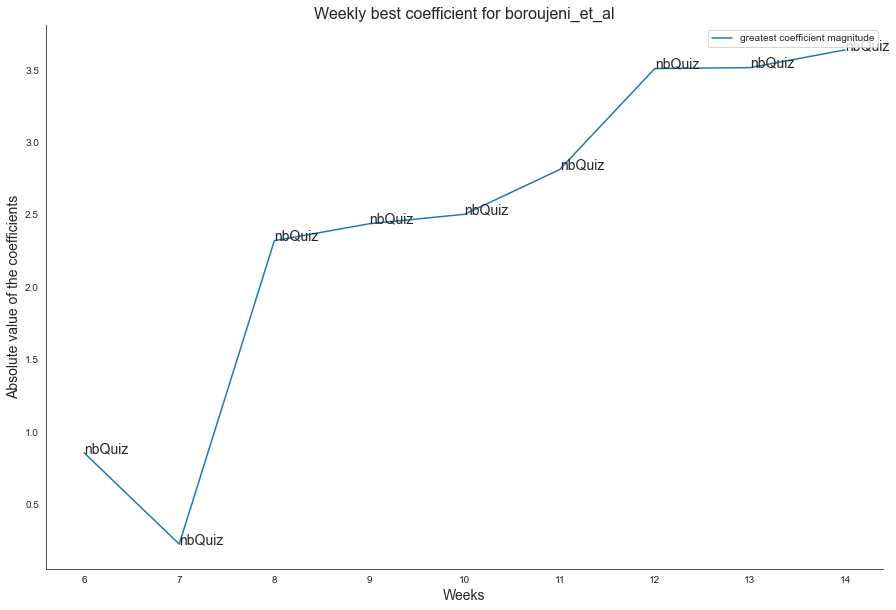

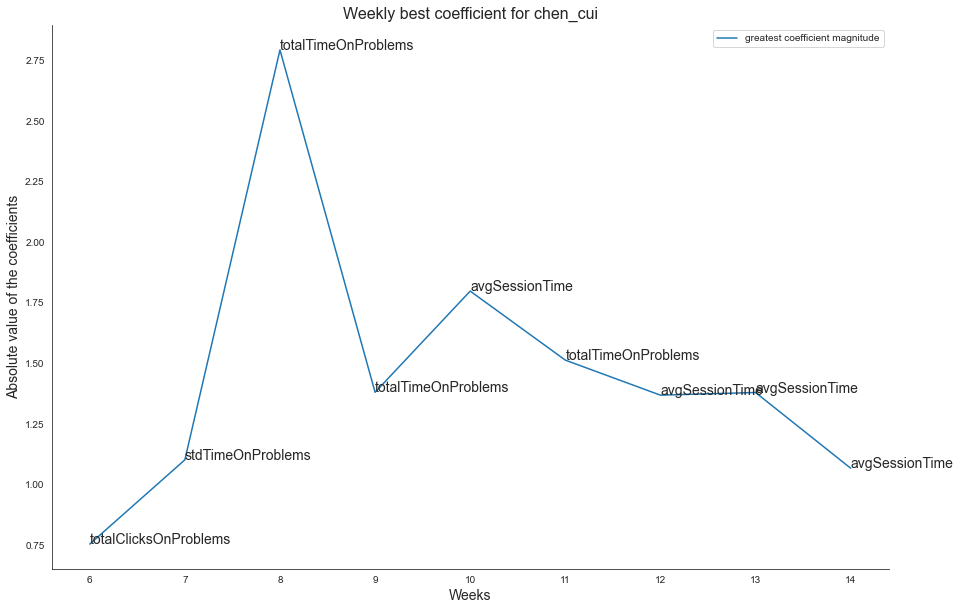

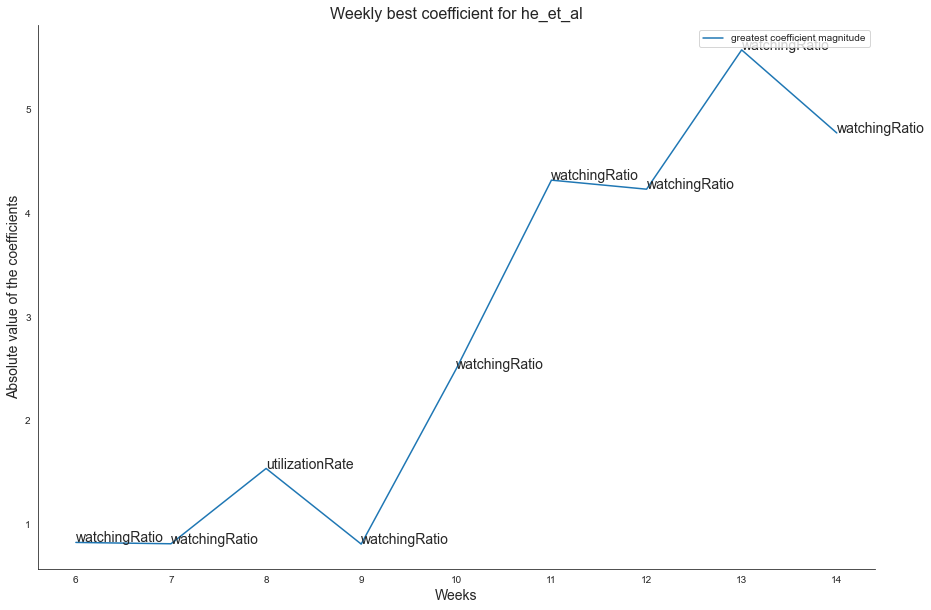

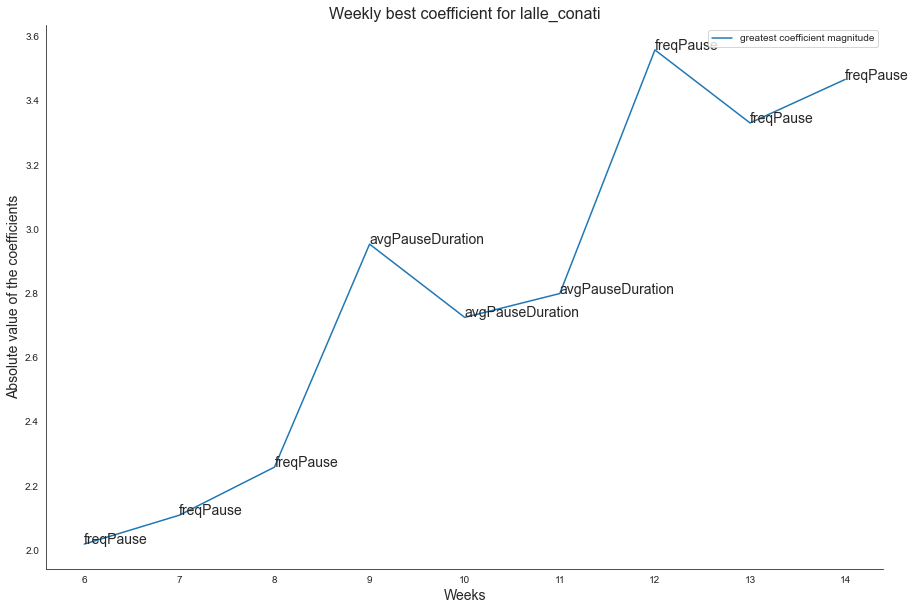

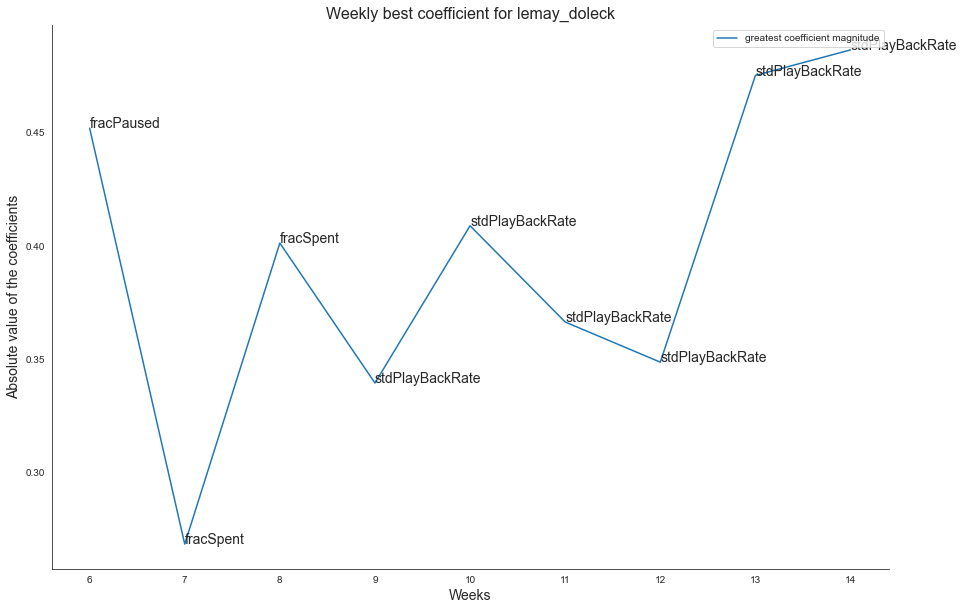

In [332]:
plot_best_coef(featureSets, tunedModels)